In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from glob import glob
from PIL import Image
from random import shuffle
from scipy.stats import pearsonr

In [3]:
# census data
CEN_IN_DIR = 'data/Experiment0/census.csv'
# census index data
IDX_IN_DIR = 'data/Experiment0/init_image.csv'
# download log data
LOG_IN_DIR = 'data/Experiment0/census_download_log.csv'
# satellite derived data
SAT_IN_DIR = 'data/GoogleStaticMap/Pred/infer/annotations_pred.json'
# visual path
VIZ_DIR = 'data/GoogleStaticMap/Visual/infer/pred'
# output path
OUT_DIR = 'data/Experiment0/Output/'
# score cutoff
SCORE_CUTOFF = 0.6

In [4]:
# read image index data frame
df = pd.merge(pd.read_csv(IDX_IN_DIR, index_col='index'),
              pd.read_csv(LOG_IN_DIR, index_col='index'),
              how='left', on='index')
# drop NA localities with no images
df = df.loc[df['status'].astype('bool'),
            ['ent', 'mun', 'loc', 'chip']]

In [5]:
# read satellite predictions
# from json annotations
with open(SAT_IN_DIR, 'r') as f:
    df_sat = json.load(f)
df_sat = [[ins['image_id_str'], ins['category_id'],
           ins['score'], ins['area']]
          for ins in df_sat]
# convert to data frames
df_sat = pd.DataFrame(
    df_sat, columns=['index', 'category_id', 'score', 'area'])
# drop low score predictions
df_sat = df_sat.loc[df_sat['score'] > SCORE_CUTOFF, :]
df_sat.set_index('index', inplace=True)
# merge with image identifiers
df_sat = pd.merge(df, df_sat, how='left', on='index')
df_sat.set_index(['ent', 'mun', 'loc'], inplace=True)

In [6]:
# read census data
df_cen = pd.read_csv(CEN_IN_DIR, index_col=['ent', 'mun', 'loc'])

In [7]:
# merge satellite and census
df = pd.merge(df_sat, df_cen, how='left', on=['ent', 'mun', 'loc'])

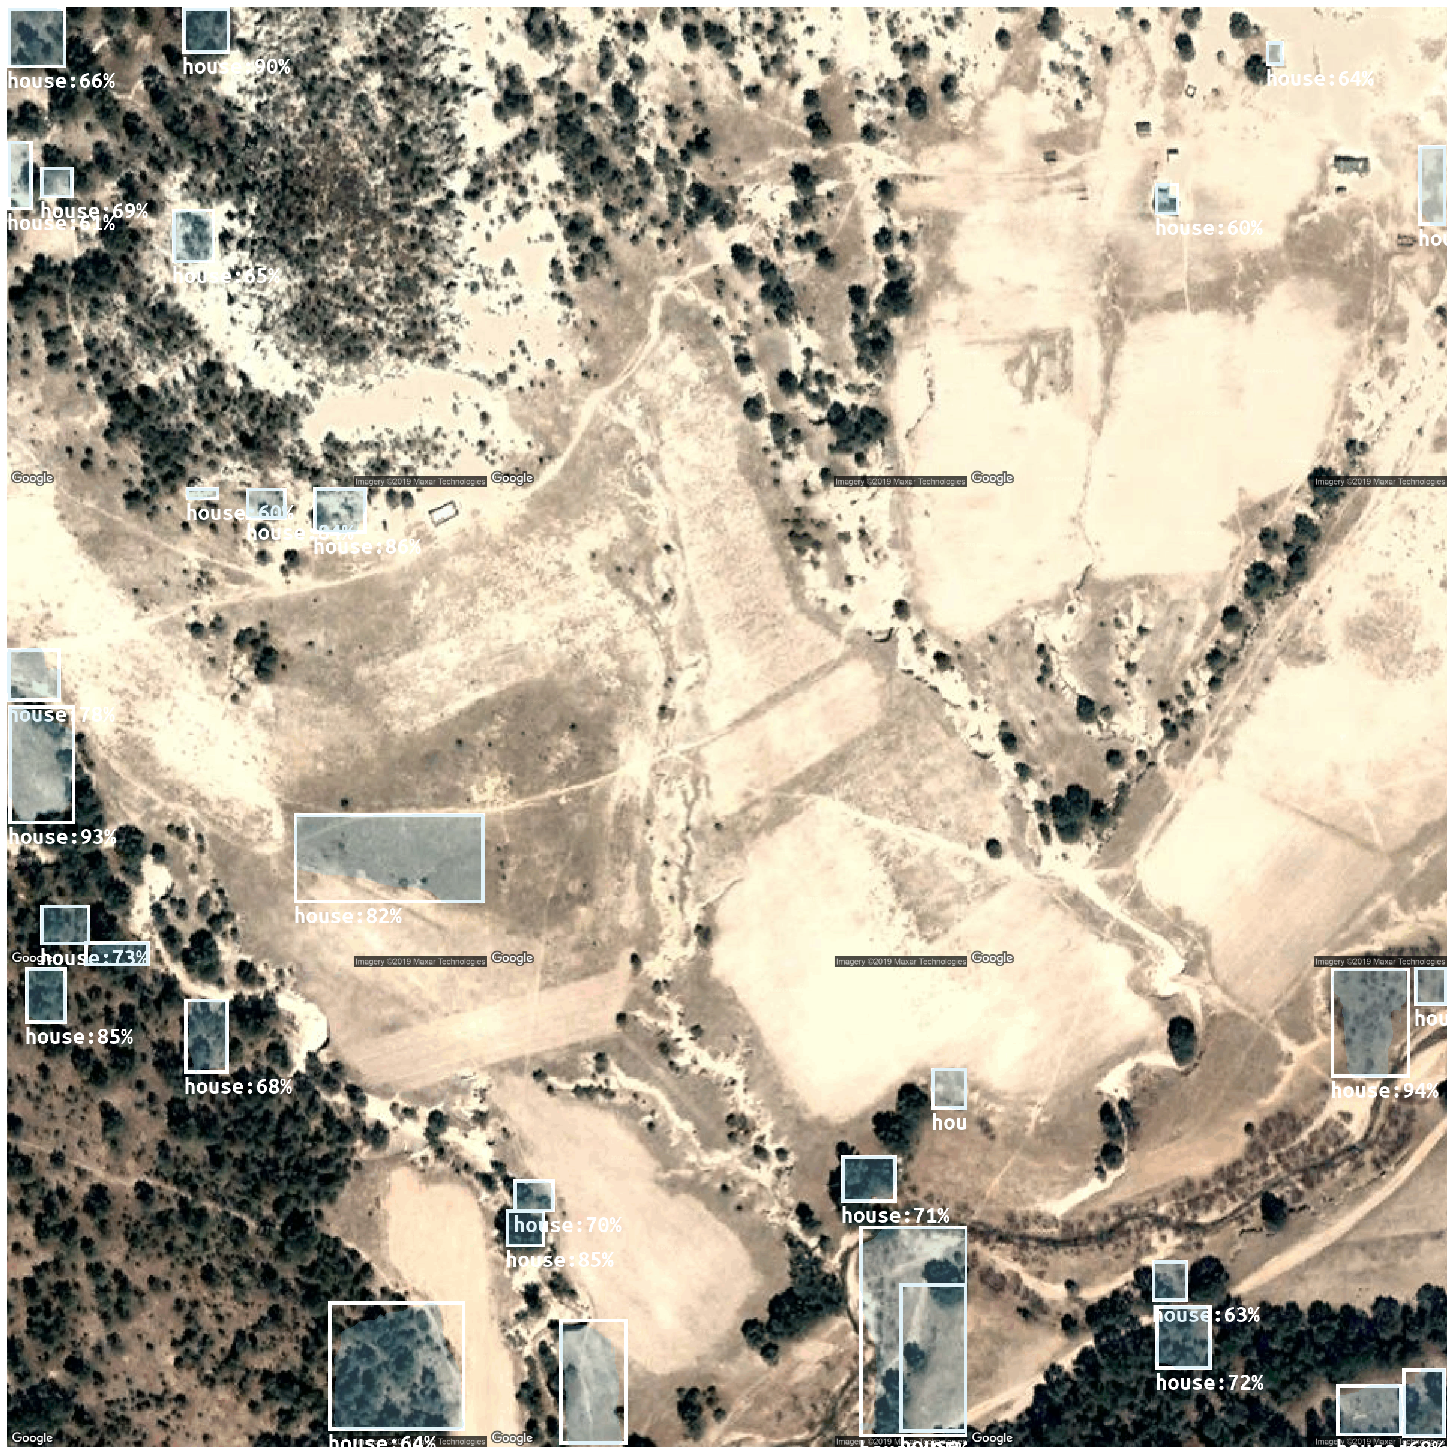

In [21]:
# randomly sample one chip
ent, mun, loc = df.sample(n=1).index.values[0]
# show merged data frame
df_sampled = df.loc[(ent, mun, loc), :].agg(
    {'POBTOT': 'mean',
     'VIVTOT': 'mean',
     'TVIVHAB': 'mean',
     'score': 'count'})
# show inference image
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
fig.subplots_adjust(
    hspace=0, wspace=0, right=1, bottom=0, left=0, top=1)
for i in range(3):
    for j in range(3):
        chip_id = (2 - i) * 3 + j
        im = plt.imread(os.path.join(
            VIZ_DIR,
            'ENT{:02d}MUN{:03d}LOC{:04d}CHIP{:02d}.png'
            .format(ent, mun, loc, chip_id)))
        ax[i, j].imshow(im)
        ax[i, j].axis('off')
fig.savefig(os.path.join(
    OUT_DIR, 'ENT{:02d}MUN{:03d}LOC{:04d}CEN{:03d}SAT{:03d}.png'
             .format(ent, mun, loc,
                     int(df_sampled['VIVTOT']),
                     int(df_sampled['score']))))

In [9]:
df_group = df.groupby(['ent', 'mun', 'loc', 'sample']).agg(
    cen_pop=pd.NamedAgg(column='POBTOT', aggfunc='mean'),
    cen_house=pd.NamedAgg(column='VIVTOT', aggfunc='mean'),
    cen_inhab=pd.NamedAgg(column='TVIVHAB', aggfunc='mean'),
    sat_house=pd.NamedAgg(column='score', aggfunc='count'))
df_group.reset_index(inplace=True)

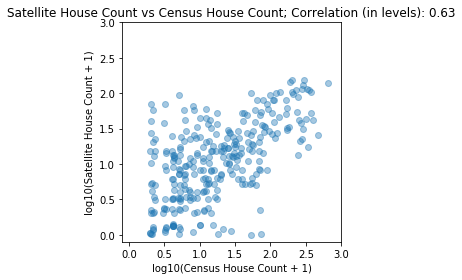

In [10]:
# plotting begins
# for full sample
name = 'full'
col_x_label = 'Census House Count'
col_y_label = 'Satellite House Count'
col_x = df_group['cen_house'].values
col_y = df_group['sat_house'].values
coef = pearsonr(col_x, col_y)
plt.plot(
    np.log10(col_x + 1 + np.random.random(len(col_x)) * 0.4),
    np.log10(col_y + 1 + np.random.random(len(col_y)) * 0.4),
    marker='o', linestyle='None', alpha=0.4)
plt.axis('square')
plt.xlim((-0.1, 3))
plt.ylim((-0.1, 3))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('log10({} + 1)'.format(col_x_label))
plt.ylabel('log10({} + 1)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}_{}.pdf'
                         .format(col_x_label, col_y_label, name)))
plt.show()
plt.close('all')

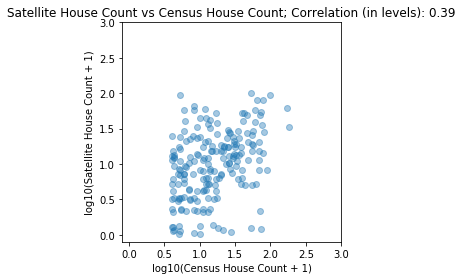

In [11]:
# for main sample
name = 'main'
col_x_label = 'Census House Count'
col_y_label = 'Satellite House Count'
col_x = df_group.loc[df_group['sample'] == 'main', 'cen_house'].values
col_y = df_group.loc[df_group['sample'] == 'main', 'sat_house'].values
coef = pearsonr(col_x, col_y)
plt.plot(
    np.log10(col_x + 1 + np.random.random(len(col_x)) * 0.4),
    np.log10(col_y + 1 + np.random.random(len(col_y)) * 0.4),
    marker='o', linestyle='None', alpha=0.4)
plt.axis('square')
plt.xlim((-0.1, 3))
plt.ylim((-0.1, 3))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('log10({} + 1)'.format(col_x_label))
plt.ylabel('log10({} + 1)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}_{}.pdf'
                         .format(col_x_label, col_y_label, name)))
plt.show()
plt.close('all')

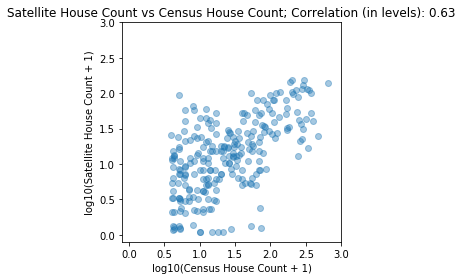

In [12]:
# for main + large sample
name = 'large'
col_x_label = 'Census House Count'
col_y_label = 'Satellite House Count'
col_x = df_group.loc[df_group['sample'].isin(['main', 'large']), 'cen_house'].values
col_y = df_group.loc[df_group['sample'].isin(['main', 'large']), 'sat_house'].values
coef = pearsonr(col_x, col_y)
plt.plot(
    np.log10(col_x + 1 + np.random.random(len(col_x)) * 0.4),
    np.log10(col_y + 1 + np.random.random(len(col_y)) * 0.4),
    marker='o', linestyle='None', alpha=0.4)
plt.axis('square')
plt.xlim((-0.1, 3))
plt.ylim((-0.1, 3))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('log10({} + 1)'.format(col_x_label))
plt.ylabel('log10({} + 1)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}_{}.pdf'
                         .format(col_x_label, col_y_label, name)))
plt.show()
plt.close('all')

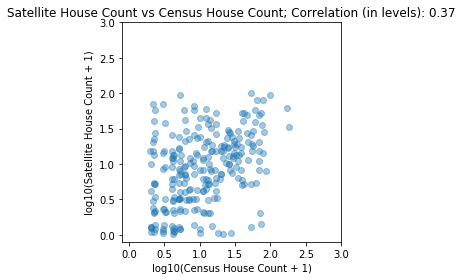

In [13]:
# for main + small sample
name = 'small'
col_x_label = 'Census House Count'
col_y_label = 'Satellite House Count'
col_x = df_group.loc[df_group['sample'].isin(['main', 'small']), 'cen_house'].values
col_y = df_group.loc[df_group['sample'].isin(['main', 'small']), 'sat_house'].values
coef = pearsonr(col_x, col_y)
plt.plot(
    np.log10(col_x + 1 + np.random.random(len(col_x)) * 0.4),
    np.log10(col_y + 1 + np.random.random(len(col_y)) * 0.4),
    marker='o', linestyle='None', alpha=0.4)
plt.axis('square')
plt.xlim((-0.1, 3))
plt.ylim((-0.1, 3))
plt.title('{} vs {}; Correlation (in levels): {:.2f}'
          .format(col_y_label, col_x_label, coef[0]))
plt.xlabel('log10({} + 1)'.format(col_x_label))
plt.ylabel('log10({} + 1)'.format(col_y_label))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,
                         '{}_vs_{}_{}.pdf'
                         .format(col_x_label, col_y_label, name)))
plt.show()
plt.close('all')